In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nrrd
import pandas as pd
import os
import sys
import SimpleITK as sitk
from tqdm import tqdm

sys.path.append("/mnt/raid/C1_ML_Analysis/source/autoencoder/src")

from nets import diffusion
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler

import monai
from monai.transforms import (    
    AsChannelFirst,
    AddChannel,
    Compose,    
    Resize,
    RandFlip,
    RandRotate,
    CenterSpatialCrop,
    ScaleIntensityRange,
    RandAdjustContrast,
    RandGaussianNoise,
    RandGaussianSmooth
)


/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/pytorch_lightning/loggers/neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune imp

In [2]:
model_fn = "/mnt/raid/C1_ML_Analysis/train_output/diffusion/extract_frames_blind_sweeps_c1_30082022_wscores_1e-4_ddpmpl64_v1.0/epoch=6-val_loss=1.30.ckpt"

NN = getattr(diffusion, "DDPMPL64")
model = NN.load_from_checkpoint(model_fn)
model.eval()
model.cuda()

DDPMPL64(
  (model): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connection):

In [3]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
inferer = DiffusionInferer(scheduler=scheduler)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.23it/s]


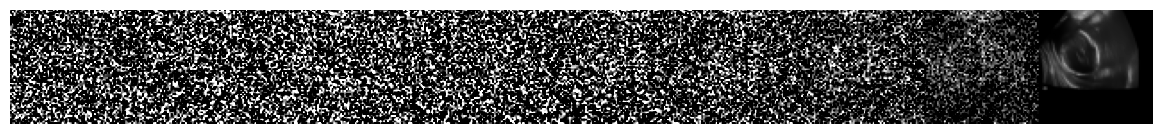

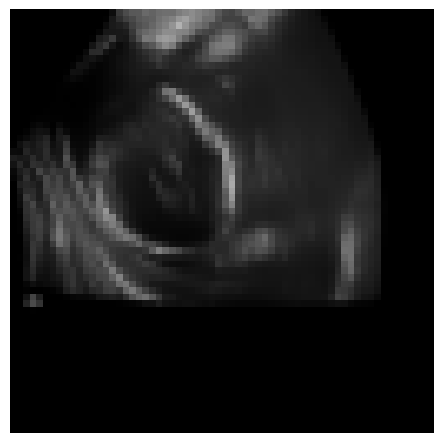

In [13]:
noise = torch.randn((1, 1, 64, 64))
noise = noise.cuda()
scheduler.set_timesteps(num_inference_steps=1000)


image, intermediates = inferer.sample(
    input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
)

chain = torch.cat(intermediates, dim=-1)

plt.figure(figsize=(12,8))
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(image[0].cpu().permute(1,2,0), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

In [5]:
model_autoencoder_fn = "/mnt/raid/C1_ML_Analysis/train_output/diffusion/extract_frames_blind_sweeps_c1_30082022_wscores_1e-4_autoencoderlowkl_v1.0/last.ckpt"

NN = getattr(diffusion, "AutoEncoderLowKL")
model_autoencoder = NN.load_from_checkpoint(model_autoencoder_fn).eval().cuda()

/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 122.20it/s]


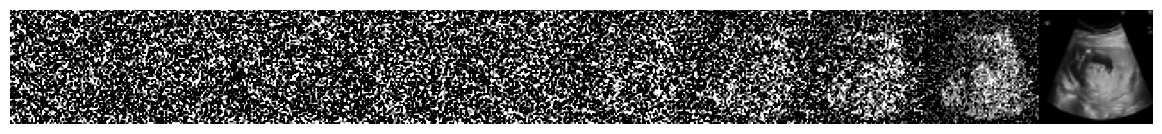

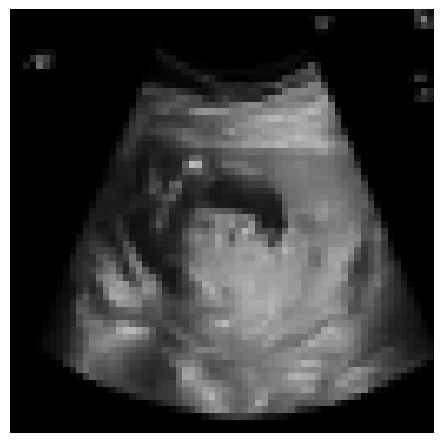

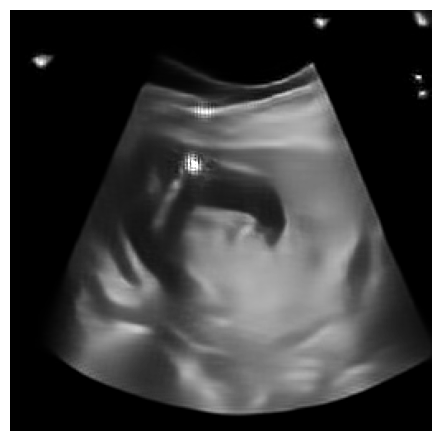

In [6]:
noise = torch.randn((1, 1, 64, 64))
noise = noise.cuda()
scheduler.set_timesteps(num_inference_steps=1000)


image, intermediates = inferer.sample(
    input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
)

# image = inferer.sample(
#     input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=False
# )

chain = torch.cat(intermediates, dim=-1)

plt.figure(figsize=(12,8))
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(image[0].cpu().permute(1,2,0), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

reconstruction, z_mu, z_sigma = model_autoencoder(image)

plt.style.use("default")
plt.imshow(reconstruction[0].detach().cpu().permute(1,2,0), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

In [7]:
sweep_fn = "/mnt/famli_netapp_shared/C1_ML_Analysis/src/blender/Pregnant_Fetus_Uterus_Blend_2-82/breech_3us_sweep_slices/1.nrrd"
sweep = sitk.ReadImage(sweep_fn)
sweep_np = sitk.GetArrayFromImage(sweep)

/tmp/ipykernel_588423/898292924.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sweep_t = torch.tensor(sweep_t).cuda().to(torch.float32).unsqueeze(0)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 121.91it/s]


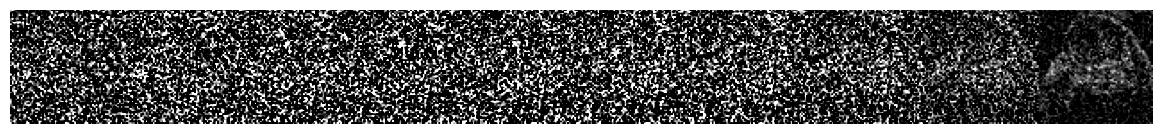

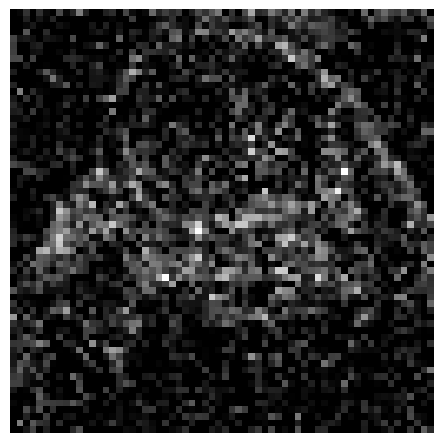

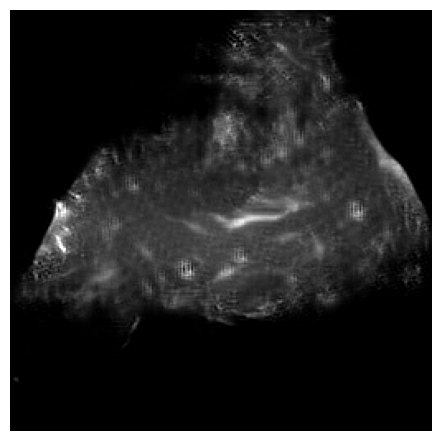

In [8]:
sweep_t = Resize([64, 64])(sweep_np)
sweep_t = torch.tensor(sweep_t).cuda().to(torch.float32).unsqueeze(0)
scheduler.set_timesteps(num_inference_steps=500)


image, intermediates = inferer.sample(
    input_noise=sweep_t, diffusion_model=model.model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
)

# image = inferer.sample(
#     input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=False
# )

chain = torch.cat(intermediates, dim=-1)

plt.figure(figsize=(12,8))
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(image[0].cpu().permute(1,2,0), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

reconstruction, z_mu, z_sigma = model_autoencoder(image)

plt.style.use("default")
plt.imshow(reconstruction[0].detach().cpu().permute(1,2,0), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

/tmp/ipykernel_588423/2748756180.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sweep_t = torch.tensor(sweep_t).cuda().to(torch.float32).unsqueeze(0)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 98.57it/s, timestep input=1]


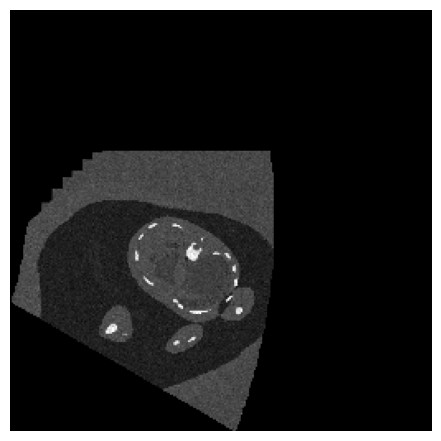

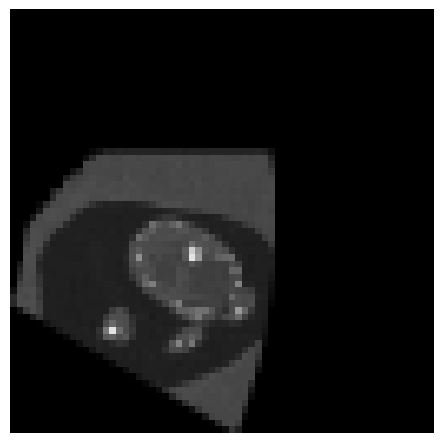

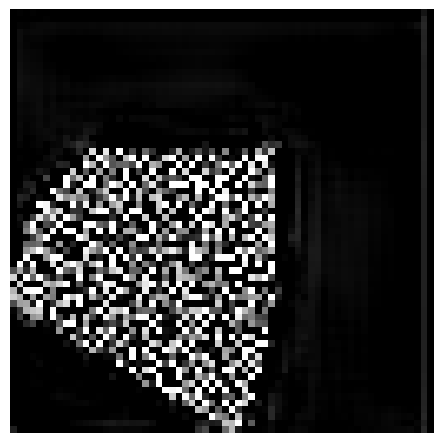

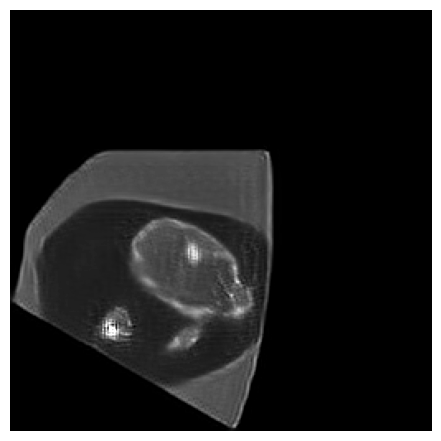

In [9]:

sweep_t = Resize([64, 64])(sweep_np)
sweep_t = torch.tensor(sweep_t).cuda().to(torch.float32).unsqueeze(0)

guidance_scale = 100.0
total_timesteps = 1000
latent_space_depth = int(total_timesteps * 0.25)

current_img = sweep_t
scheduler_ddim = DDIMScheduler(num_train_timesteps=1000)
inferer_ddim = DiffusionInferer(scheduler_ddim)

scheduler_ddim.set_timesteps(num_inference_steps=total_timesteps)

## Encoding

scheduler_ddim.clip_sample = False
# class_embedding = embed(torch.zeros(1).long().to(device)).unsqueeze(1)
progress_bar = tqdm(range(latent_space_depth))
for i in progress_bar:  # go through the noising process
    t = i
    with torch.no_grad():
        model_output = model.model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device))# , context=class_embedding)
    current_img, _ = scheduler_ddim.reversed_step(model_output, t, current_img)
    progress_bar.set_postfix({"timestep input": t})

latent_img = current_img

## Decoding
# conditioning = torch.cat([torch.zeros(1).long(), torch.ones(1).long()], dim=0).to(device)
# class_embedding = embed(conditioning).unsqueeze(1)

progress_bar = tqdm(range(latent_space_depth))
for i in progress_bar:  # go through the denoising process
    t = latent_space_depth - i
    current_img_double = torch.cat([current_img] * 2)
    with torch.no_grad():
        model_output = model.model(
            current_img_double, timesteps=torch.Tensor([t, t]).to(current_img.device)#, context=class_embedding
        )
    noise_pred_uncond, noise_pred_text = model_output.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    current_img, _ = scheduler_ddim.step(noise_pred, t, current_img)
    progress_bar.set_postfix({"timestep input": t})
    torch.cuda.empty_cache()

plt.style.use("default")
plt.imshow(sweep_np[0], vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(current_img.detach().cpu()[0][0], vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(latent_img.detach().cpu()[0][0], vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

reconstruction, z_mu, z_sigma = model_autoencoder(sweep_t)

plt.style.use("default")
plt.imshow(reconstruction[0].detach().cpu().permute(1,2,0), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

In [10]:
model_vqvae_fn = "/mnt/raid/C1_ML_Analysis/train_output/diffusion/extract_frames_blind_sweeps_c1_30082022_wscores_1e-4_vqvae_1.0/epoch=19-val_loss=0.03.ckpt"

NN = getattr(diffusion, "VQVAEPL")
model_vqvae = NN.load_from_checkpoint(model_vqvae_fn).eval().cuda()

/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/tmp/ipykernel_588423/442432524.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sweep_t = torch.tensor(sweep_t).cuda().to(torch.float32).unsqueeze(0)


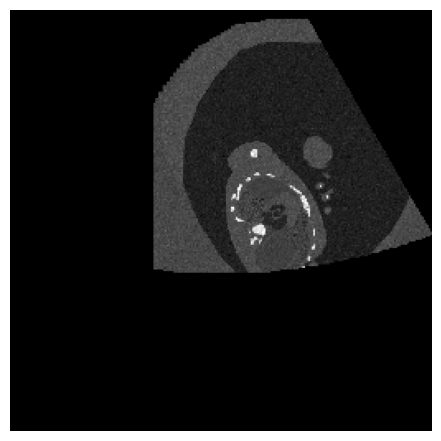

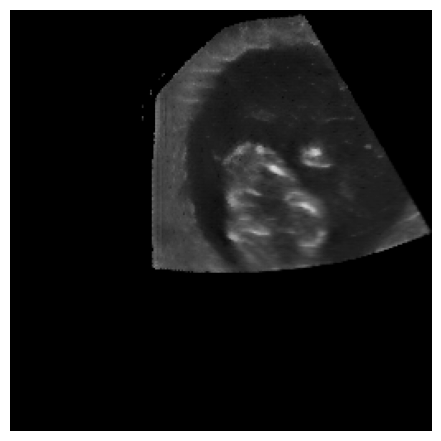

In [11]:
sweep_fn = "/mnt/famli_netapp_shared/C1_ML_Analysis/src/blender/Pregnant_Fetus_Uterus_Blend_2-82/breech_3us_sweep_slices/100.nrrd"
sweep = sitk.ReadImage(sweep_fn)
sweep_np = sitk.GetArrayFromImage(sweep).transpose([0,2,1])

sweep_t = Resize([256, 256])(sweep_np)
sweep_t = torch.tensor(sweep_t).cuda().to(torch.float32).unsqueeze(0)

plt.style.use("default")
plt.imshow(sweep_np[0], vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()

reconstruction, quantization_loss = model_vqvae(sweep_t)

plt.style.use("default")
plt.imshow(reconstruction[0].detach().cpu().permute(1,2,0), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()